In [1]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.1 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import segmentation_models_pytorch as smp
from sklearn.metrics import jaccard_score
import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings('ignore')

# Kiểm tra GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda:0


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.7 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Định nghĩa đường dẫn
TRAIN_IMG_DIR = '/kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input'
TRAIN_MASK_DIR = '/kaggle/input/isic-2018-task12/ISIC2018_Task1_Training_GroundTruth/ISIC2018_Task1_Training_GroundTruth'
VAL_IMG_DIR = '/kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input'
VAL_MASK_DIR = '/kaggle/input/isic-2018-task12/ISIC2018_Task1_Validation_GroundTruth/ISIC2018_Task1_Validation_GroundTruth'
TEST_IMG_DIR = '/kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Test_Input/ISIC2018_Task1-2_Test_Input'
TEST_MASK_DIR = '/kaggle/input/isic-2018-task12/ISIC2018_Task1_Test_GroundTruth/ISIC2018_Task1_Test_GroundTruth'

# Tạo các thư mục để lưu kết quả nếu chưa tồn tại
os.makedirs('./models', exist_ok=True)
os.makedirs('./results', exist_ok=True)
os.makedirs('./results/predictions', exist_ok=True)

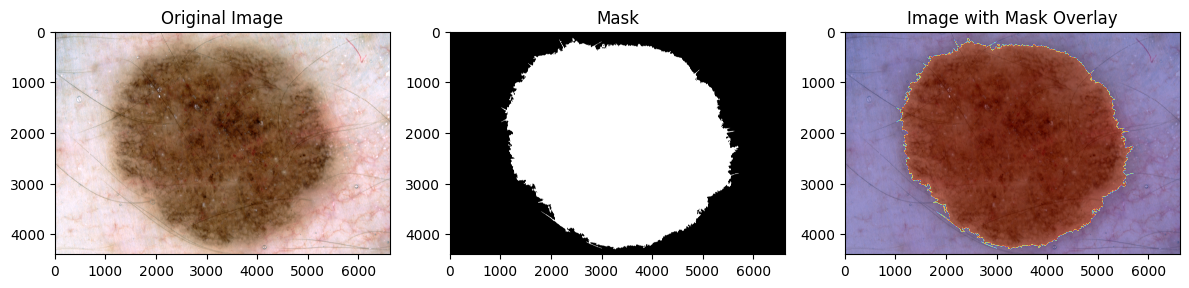

Số lượng ảnh huấn luyện: 2596
Số lượng ảnh validation: 102
Số lượng ảnh test: 1002


In [4]:
def display_image_and_mask(image_path, mask_path):
    """Hiển thị ảnh và mask tương ứng"""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Không thể đọc file ảnh: {image_path}")
        return
        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Không thể đọc file mask: {mask_path}")
        return
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.4, cmap='jet')
    plt.title('Image with Mask Overlay')
    
    plt.tight_layout()
    plt.show()

# Lấy một ví dụ ngẫu nhiên từ tập huấn luyện
train_imgs = [f for f in os.listdir(TRAIN_IMG_DIR) if not f.startswith('.')]

if len(train_imgs) > 0:
    random_idx = random.randint(0, len(train_imgs)-1)
    img_name = train_imgs[random_idx]
    img_path = os.path.join(TRAIN_IMG_DIR, img_name)
    
    # Tạo tên cho file mask tương ứng
    img_base = os.path.splitext(img_name)[0]
    mask_name = f"{img_base}_segmentation.png"
    mask_path = os.path.join(TRAIN_MASK_DIR, mask_name)
    
    if os.path.exists(mask_path):
        display_image_and_mask(img_path, mask_path)
    else:
        print(f"Không tìm thấy mask tương ứng: {mask_path}")
    
# Thống kê dữ liệu
print(f"Số lượng ảnh huấn luyện: {len([f for f in os.listdir(TRAIN_IMG_DIR) if not f.startswith('.')])}")
print(f"Số lượng ảnh validation: {len([f for f in os.listdir(VAL_IMG_DIR) if not f.startswith('.')])}")
print(f"Số lượng ảnh test: {len([f for f in os.listdir(TEST_IMG_DIR) if not f.startswith('.')])}")

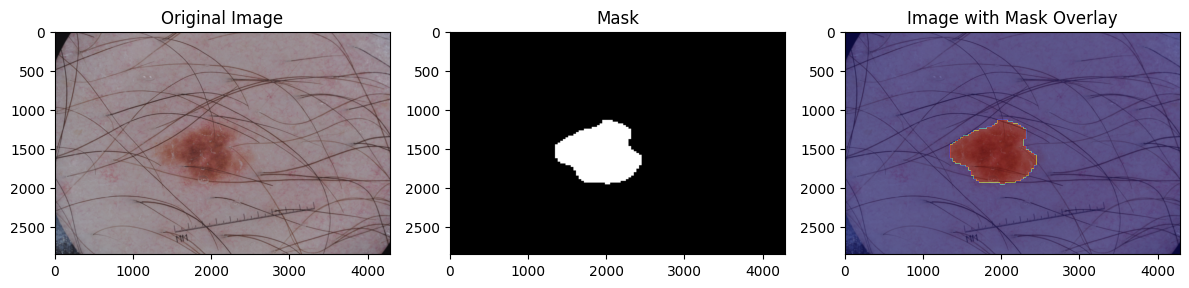

Số lượng ảnh huấn luyện: 2596
Số lượng ảnh validation: 102
Số lượng ảnh test: 1002


In [5]:
def display_image_and_mask(image_path, mask_path):
    """Hiển thị ảnh và mask tương ứng"""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Không thể đọc file ảnh: {image_path}")
        return
        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Không thể đọc file mask: {mask_path}")
        return
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.4, cmap='jet')
    plt.title('Image with Mask Overlay')
    
    plt.tight_layout()
    plt.show()

# Lấy một ví dụ ngẫu nhiên từ tập huấn luyện
train_imgs = [f for f in os.listdir(TRAIN_IMG_DIR) if not f.startswith('.')]

if len(train_imgs) > 0:
    random_idx = random.randint(0, len(train_imgs)-1)
    img_name = train_imgs[random_idx]
    img_path = os.path.join(TRAIN_IMG_DIR, img_name)
    
    # Tạo tên cho file mask tương ứng
    img_base = os.path.splitext(img_name)[0]
    mask_name = f"{img_base}_segmentation.png"
    mask_path = os.path.join(TRAIN_MASK_DIR, mask_name)
    
    if os.path.exists(mask_path):
        display_image_and_mask(img_path, mask_path)
    else:
        print(f"Không tìm thấy mask tương ứng: {mask_path}")
    
# Thống kê dữ liệu
print(f"Số lượng ảnh huấn luyện: {len([f for f in os.listdir(TRAIN_IMG_DIR) if not f.startswith('.')])}")
print(f"Số lượng ảnh validation: {len([f for f in os.listdir(VAL_IMG_DIR) if not f.startswith('.')])}")
print(f"Số lượng ảnh test: {len([f for f in os.listdir(TEST_IMG_DIR) if not f.startswith('.')])}")

In [6]:
# Kích thước ảnh đầu vào cho mô hình
IMG_SIZE = 384  # Tăng kích thước cho DeepLabV3+ để nắm bắt nhiều chi tiết hơn

# Định nghĩa các phép biến đổi cho tập huấn luyện
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.OneOf([
        A.GridDistortion(p=0.5),
        A.ElasticTransform(p=0.5),
        A.OpticalDistortion(p=0.5)
    ], p=0.3),
    A.CLAHE(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Định nghĩa các phép biến đổi cho tập validation và test
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [7]:
class SkinLesionDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None, transform=None, is_test=False):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.is_test = is_test
        self.ids = [f for f in os.listdir(img_dir) if not f.startswith('.')]
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        img_name = self.ids[idx]
        img_path = os.path.join(self.img_dir, img_name)
        
        # Kiểm tra xem file có tồn tại không
        if not os.path.exists(img_path):
            print(f"File không tồn tại: {img_path}")
            # Trả về một ảnh và mask rỗng với kích thước phù hợp
            if self.is_test:
                dummy_img = torch.zeros((3, IMG_SIZE, IMG_SIZE))
                return dummy_img, img_name
            else:
                dummy_img = torch.zeros((3, IMG_SIZE, IMG_SIZE))
                dummy_mask = torch.zeros((1, IMG_SIZE, IMG_SIZE))
                return dummy_img, dummy_mask
        
        # Đọc ảnh và kiểm tra
        img = cv2.imread(img_path)
        if img is None:
            print(f"Không thể đọc file: {img_path}")
            # Trả về một ảnh và mask rỗng với kích thước phù hợp
            if self.is_test:
                dummy_img = torch.zeros((3, IMG_SIZE, IMG_SIZE))
                return dummy_img, img_name
            else:
                dummy_img = torch.zeros((3, IMG_SIZE, IMG_SIZE))
                dummy_mask = torch.zeros((1, IMG_SIZE, IMG_SIZE))
                return dummy_img, dummy_mask
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.is_test:
            if self.transform:
                transformed = self.transform(image=img)
                img = transformed["image"]
            return img, img_name
        else:
            # Tìm mask tương ứng - thêm "_segmentation" vào tên file
            img_base = os.path.splitext(img_name)[0]
            mask_name = f"{img_base}_segmentation.png"
            mask_path = os.path.join(self.mask_dir, mask_name)
            
            # Kiểm tra xem file mask có tồn tại không
            if not os.path.exists(mask_path):
                print(f"File mask không tồn tại: {mask_path}")
                dummy_mask = torch.zeros((1, IMG_SIZE, IMG_SIZE))
                if self.transform:
                    transformed = self.transform(image=img)
                    img = transformed["image"]
                return img, dummy_mask
            
            # Đọc mask và kiểm tra
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Không thể đọc file mask: {mask_path}")
                dummy_mask = torch.zeros((1, IMG_SIZE, IMG_SIZE))
                if self.transform:
                    transformed = self.transform(image=img)
                    img = transformed["image"]
                return img, dummy_mask
                
            mask = mask / 255.0  # Chuẩn hóa về khoảng [0, 1]
            
            if self.transform:
                transformed = self.transform(image=img, mask=mask)
                img = transformed["image"]
                mask = transformed["mask"]
            
            return img, mask.unsqueeze(0).float()

# Tạo các dataset
train_dataset = SkinLesionDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform=train_transform)
val_dataset = SkinLesionDataset(VAL_IMG_DIR, VAL_MASK_DIR, transform=val_transform)
test_dataset = SkinLesionDataset(TEST_IMG_DIR, transform=val_transform, is_test=True)

# Tạo các dataloader
batch_size = 4  # Giảm batch size cho DeepLabV3+

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2, 
    pin_memory=True if torch.cuda.is_available() else False,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=1, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Số lượng batch trong train_loader: {len(train_loader)}")
print(f"Số lượng batch trong val_loader: {len(val_loader)}")
print(f"Số lượng batch trong test_loader: {len(test_loader)}")

Số lượng batch trong train_loader: 649
Số lượng batch trong val_loader: 26
Số lượng batch trong test_loader: 1002


In [8]:
# Sử dụng DeepLabV3+ thay vì UNet++
def get_model():
    model = smp.DeepLabV3Plus(
        encoder_name="efficientnet-b7",  # encoder backbone
        encoder_weights="imagenet",  # pre-training weights
        in_channels=3,  # input channels
        classes=1,  # output channels (1 cho binary mask)
        activation="sigmoid"  # final activation
    )
    return model

model = get_model()
model = model.to(device)
print(f"Mô hình DeepLabV3+ với backbone EfficientNet-B7 đã được tạo.")

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/267M [00:00<?, ?B/s]

Mô hình DeepLabV3+ với backbone EfficientNet-B7 đã được tạo.


In [9]:
# Định nghĩa hàm mất mát kết hợp
class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=0.3, weight_bce=0.4, weight_lovasz=0.3):
        super(CombinedLoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce
        self.weight_lovasz = weight_lovasz
        self.bce_loss = nn.BCELoss()
        
    def forward(self, inputs, targets):
        # Dice Loss
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + 1e-5) / (inputs_flat.sum() + targets_flat.sum() + 1e-5)
        
        # BCE Loss
        bce = self.bce_loss(inputs, targets)
        
        # Lovasz Loss (approximates IoU loss)
        lovasz_loss = self._lovasz_hinge(inputs, targets)
        
        # Combined loss
        return self.weight_dice * dice_loss + self.weight_bce * bce + self.weight_lovasz * lovasz_loss
    
    def _lovasz_grad(self, gt_sorted):
        """Compute gradient of the Lovasz extension w.r.t sorted errors"""
        p = len(gt_sorted)
        gts = gt_sorted.sum()
        intersection = gts - gt_sorted.float().cumsum(0)
        union = gts + (1 - gt_sorted).float().cumsum(0)
        jaccard = 1. - intersection / union
        if p > 1:  # avoid division by zero
            jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
        return jaccard
    
    def _lovasz_hinge(self, logits, labels, per_image=True):
        """Binary Lovasz hinge loss"""
        if per_image:
            loss = 0
            for i in range(logits.shape[0]):
                loss += self._lovasz_hinge_flat(logits[i].contiguous(), labels[i].contiguous())
            return loss / logits.shape[0]
        else:
            return self._lovasz_hinge_flat(logits.view(-1), labels.view(-1))
    
    def _lovasz_hinge_flat(self, logits, labels):
        """Binary Lovasz hinge loss (flat version)"""
        if logits.numel() == 0:
            return logits.sum() * 0.
        
        if len(logits.shape) > 1:
            logits = logits.view(-1)
        if len(labels.shape) > 1:
            labels = labels.view(-1)
            
        signs = 2. * labels.float() - 1.
        errors = (1. - logits * signs)
        
        errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
        perm = perm.data
        gt_sorted = labels[perm]
        grad = self._lovasz_grad(gt_sorted)
        
        loss = torch.dot(F.relu(errors_sorted), grad)
        return loss

# Định nghĩa hàm đánh giá metrics
def evaluate_metrics(pred, mask):
    pred_binary = (pred > 0.5).float()
    
    # IoU (Jaccard)
    intersection = (pred_binary * mask).sum()
    union = pred_binary.sum() + mask.sum() - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    
    # Dice
    dice = (2. * intersection + 1e-7) / (pred_binary.sum() + mask.sum() + 1e-7)
    
    # Precision & Recall
    true_positives = (pred_binary * mask).sum()
    pred_positives = pred_binary.sum()
    actual_positives = mask.sum()
    
    precision = (true_positives + 1e-7) / (pred_positives + 1e-7)
    recall = (true_positives + 1e-7) / (actual_positives + 1e-7)
    
    # F1 Score
    f1 = (2 * precision * recall + 1e-7) / (precision + recall + 1e-7)
    
    return {
        'iou': iou.item(),
        'dice': dice.item(),
        'precision': precision.item(),
        'recall': recall.item(),
        'f1': f1.item()
    }

# Định nghĩa optimizer và scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=10,  # Số epochs trong chu kỳ đầu tiên
    T_mult=1, 
    eta_min=1e-6
)

criterion = CombinedLoss(weight_dice=0.3, weight_bce=0.4, weight_lovasz=0.3)

In [10]:
# Thiết lập các tham số huấn luyện
num_epochs = 30
best_val_loss = float('inf')
best_val_iou = 0
early_stop_patience = 10
epochs_no_improve = 0

# Danh sách lưu trữ loss và metrics
train_losses = []
val_losses = []
train_metrics = []
val_metrics = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_metric_values = {'iou': 0, 'dice': 0, 'precision': 0, 'recall': 0, 'f1': 0}
    
    for batch_idx, (images, masks) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")):
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass và optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Tính toán metrics
        train_loss += loss.item()
        batch_metrics = evaluate_metrics(outputs, masks)
        for k, v in batch_metrics.items():
            train_metric_values[k] += v
        
    # Cập nhật scheduler
    scheduler.step()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Tính giá trị trung bình cho các metrics
    for k in train_metric_values:
        train_metric_values[k] /= len(train_loader)
    train_metrics.append(train_metric_values)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_metric_values = {'iou': 0, 'dice': 0, 'precision': 0, 'recall': 0, 'f1': 0}
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            val_loss += loss.item()
            batch_metrics = evaluate_metrics(outputs, masks)
            for k, v in batch_metrics.items():
                val_metric_values[k] += v
            
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Tính giá trị trung bình cho các metrics
    for k in val_metric_values:
        val_metric_values[k] /= len(val_loader)
    val_metrics.append(val_metric_values)
    
    # In kết quả
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train IoU: {train_metric_values["iou"]:.4f}, Train Dice: {train_metric_values["dice"]:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val IoU: {val_metric_values["iou"]:.4f}, Val Dice: {val_metric_values["dice"]:.4f}')
    
    # Lưu model tốt nhất theo IoU
    if val_metric_values['iou'] > best_val_iou:
        best_val_iou = val_metric_values['iou']
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_iou': val_metric_values['iou'],
            'val_dice': val_metric_values['dice'],
        }, './models/best_model_iou.pth')
        print("Đã lưu model tốt nhất theo IoU!")
    # Lưu model tốt nhất theo loss
    elif val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_iou': val_metric_values['iou'],
            'val_dice': val_metric_values['dice'],
        }, './models/best_model_loss.pth')
        print("Đã lưu model tốt nhất theo Loss!")
    else:
        epochs_no_improve += 1
        
    # Early stopping
    if epochs_no_improve >= early_stop_patience:
        print(f'Early stopping triggered after {epoch+1} epochs!')
        break
        
    print('-' * 60)

Epoch 1/30 [Train]:  65%|██████▍   | 420/649 [03:45<01:41,  2.25it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 1/30 [Train]:  84%|████████▍ | 548/649 [04:48<01:08,  1.47it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 1/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:05,  2.39it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 1/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  2.80it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 1/30 [Val]: 100%|██████████| 26/26 [00:08<00:00,  2.93it/s]


Epoch 1/30
Train Loss: 0.4825, Train IoU: 0.6988, Train Dice: 0.8093
Val Loss: 0.4022, Val IoU: 0.7896, Val Dice: 0.8796
Đã lưu model tốt nhất theo IoU!
------------------------------------------------------------


Epoch 2/30 [Train]:   6%|▋         | 42/649 [00:24<04:38,  2.18it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 2/30 [Train]:  88%|████████▊ | 572/649 [04:42<00:48,  1.59it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 2/30 [Val]:  54%|█████▍    | 14/26 [00:04<00:04,  2.79it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 2/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.27it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 2/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.45it/s]


Epoch 2/30
Train Loss: 0.3809, Train IoU: 0.7919, Train Dice: 0.8788
Val Loss: 0.3741, Val IoU: 0.8062, Val Dice: 0.8896
Đã lưu model tốt nhất theo IoU!
------------------------------------------------------------


Epoch 3/30 [Train]:  21%|██        | 137/649 [01:09<03:49,  2.23it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 3/30 [Train]:  51%|█████     | 332/649 [02:47<02:36,  2.02it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 3/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.78it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 3/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.40it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 3/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.46it/s]


Epoch 3/30
Train Loss: 0.3569, Train IoU: 0.8128, Train Dice: 0.8930
Val Loss: 0.3731, Val IoU: 0.8000, Val Dice: 0.8822
Đã lưu model tốt nhất theo Loss!
------------------------------------------------------------


Epoch 4/30 [Train]:  36%|███▌      | 232/649 [01:57<04:22,  1.59it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 4/30 [Train]:  73%|███████▎  | 475/649 [03:57<01:30,  1.91it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 4/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:05,  2.23it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 4/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:04,  2.67it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 4/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.26it/s]


Epoch 4/30
Train Loss: 0.3488, Train IoU: 0.8229, Train Dice: 0.8994
Val Loss: 0.3494, Val IoU: 0.8224, Val Dice: 0.8975
Đã lưu model tốt nhất theo IoU!
------------------------------------------------------------


Epoch 5/30 [Train]:  84%|████████▍ | 545/649 [04:28<00:51,  2.01it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 5/30 [Train]:  97%|█████████▋| 628/649 [05:09<00:09,  2.25it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 5/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.75it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 5/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.26it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 5/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.44it/s]


Epoch 5/30
Train Loss: 0.3412, Train IoU: 0.8316, Train Dice: 0.9050
Val Loss: 0.3537, Val IoU: 0.8282, Val Dice: 0.9038
Đã lưu model tốt nhất theo IoU!
------------------------------------------------------------


Epoch 6/30 [Train]:  60%|█████▉    | 389/649 [03:14<02:05,  2.08it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 6/30 [Train]:  67%|██████▋   | 436/649 [03:36<01:35,  2.23it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 6/30 [Val]:  54%|█████▍    | 14/26 [00:04<00:04,  2.74it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 6/30 [Val]:  62%|██████▏   | 16/26 [00:05<00:02,  3.55it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 6/30 [Val]: 100%|██████████| 26/26 [00:08<00:00,  3.21it/s]


Epoch 6/30
Train Loss: 0.3363, Train IoU: 0.8372, Train Dice: 0.9086
Val Loss: 0.3662, Val IoU: 0.8202, Val Dice: 0.8993
------------------------------------------------------------


Epoch 7/30 [Train]:  42%|████▏     | 271/649 [02:18<03:11,  1.97it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 7/30 [Train]:  48%|████▊     | 313/649 [02:39<03:49,  1.46it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 7/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.53it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 7/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  2.99it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 7/30 [Val]: 100%|██████████| 26/26 [00:08<00:00,  3.23it/s]


Epoch 7/30
Train Loss: 0.3318, Train IoU: 0.8438, Train Dice: 0.9128
Val Loss: 0.3623, Val IoU: 0.8183, Val Dice: 0.8976
------------------------------------------------------------


Epoch 8/30 [Train]:  96%|█████████▋| 626/649 [05:09<00:11,  2.06it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 8/30 [Train]:  99%|█████████▉| 643/649 [05:16<00:02,  2.26it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 8/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.57it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 8/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.09it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 8/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.31it/s]


Epoch 8/30
Train Loss: 0.3260, Train IoU: 0.8506, Train Dice: 0.9173
Val Loss: 0.3634, Val IoU: 0.8188, Val Dice: 0.8972
------------------------------------------------------------


Epoch 9/30 [Train]:  12%|█▏        | 75/649 [00:39<06:05,  1.57it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 9/30 [Train]:  66%|██████▌   | 427/649 [03:35<01:38,  2.26it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 9/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.58it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 9/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.07it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 9/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.36it/s]


Epoch 9/30
Train Loss: 0.3253, Train IoU: 0.8522, Train Dice: 0.9182
Val Loss: 0.3653, Val IoU: 0.8182, Val Dice: 0.8968
------------------------------------------------------------


Epoch 10/30 [Train]:   1%|▏         | 9/649 [00:05<05:17,  2.02it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 10/30 [Train]:  62%|██████▏   | 404/649 [03:19<01:54,  2.14it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 10/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.58it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 10/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.22it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 10/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.31it/s]


Epoch 10/30
Train Loss: 0.3241, Train IoU: 0.8529, Train Dice: 0.9182
Val Loss: 0.3624, Val IoU: 0.8205, Val Dice: 0.8983
------------------------------------------------------------


Epoch 11/30 [Train]:  38%|███▊      | 248/649 [02:06<03:06,  2.15it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 11/30 [Train]:  40%|███▉      | 258/649 [02:10<02:53,  2.25it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 11/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.62it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 11/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.16it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 11/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.44it/s]


Epoch 11/30
Train Loss: 0.3392, Train IoU: 0.8335, Train Dice: 0.9064
Val Loss: 0.3413, Val IoU: 0.8402, Val Dice: 0.9108
Đã lưu model tốt nhất theo IoU!
------------------------------------------------------------


Epoch 12/30 [Train]:  27%|██▋       | 173/649 [01:26<03:35,  2.21it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 12/30 [Train]:  29%|██▉       | 190/649 [01:35<03:42,  2.06it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 12/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.51it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 12/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.16it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 12/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.36it/s]


Epoch 12/30
Train Loss: 0.3382, Train IoU: 0.8318, Train Dice: 0.9048
Val Loss: 0.3919, Val IoU: 0.7911, Val Dice: 0.8817
------------------------------------------------------------


Epoch 13/30 [Train]:   4%|▍         | 27/649 [00:14<05:05,  2.04it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 13/30 [Train]:  45%|████▌     | 295/649 [02:26<02:59,  1.98it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 13/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.63it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 13/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.11it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 13/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.34it/s]


Epoch 13/30
Train Loss: 0.3356, Train IoU: 0.8369, Train Dice: 0.9080
Val Loss: 0.3412, Val IoU: 0.8423, Val Dice: 0.9112
Đã lưu model tốt nhất theo IoU!
------------------------------------------------------------


Epoch 14/30 [Train]:  38%|███▊      | 244/649 [02:02<02:59,  2.26it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 14/30 [Train]:  78%|███████▊  | 507/649 [04:10<01:02,  2.26it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 14/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.64it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 14/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.17it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 14/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.40it/s]


Epoch 14/30
Train Loss: 0.3310, Train IoU: 0.8414, Train Dice: 0.9112
Val Loss: 0.3465, Val IoU: 0.8404, Val Dice: 0.9107
------------------------------------------------------------


Epoch 15/30 [Train]:  13%|█▎        | 82/649 [00:41<06:14,  1.51it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 15/30 [Train]:  75%|███████▌  | 487/649 [04:00<01:14,  2.17it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 15/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.59it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 15/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.12it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 15/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.37it/s]


Epoch 15/30
Train Loss: 0.3260, Train IoU: 0.8502, Train Dice: 0.9169
Val Loss: 0.3674, Val IoU: 0.8187, Val Dice: 0.8969
------------------------------------------------------------


Epoch 16/30 [Train]:   4%|▎         | 23/649 [00:13<04:37,  2.25it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 16/30 [Train]:  31%|███       | 198/649 [01:37<03:27,  2.17it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 16/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.54it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 16/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  2.95it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 16/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.31it/s]


Epoch 16/30
Train Loss: 0.3208, Train IoU: 0.8561, Train Dice: 0.9204
Val Loss: 0.3418, Val IoU: 0.8405, Val Dice: 0.9115
------------------------------------------------------------


Epoch 17/30 [Train]:   1%|▏         | 9/649 [00:06<08:01,  1.33it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 17/30 [Train]:  88%|████████▊ | 572/649 [04:45<00:49,  1.56it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 17/30 [Val]:  54%|█████▍    | 14/26 [00:04<00:04,  2.71it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 17/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.12it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 17/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.42it/s]


Epoch 17/30
Train Loss: 0.3194, Train IoU: 0.8584, Train Dice: 0.9218
Val Loss: 0.3521, Val IoU: 0.8388, Val Dice: 0.9085
------------------------------------------------------------


Epoch 18/30 [Train]:  13%|█▎        | 87/649 [00:42<04:11,  2.23it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 18/30 [Train]:  89%|████████▉ | 578/649 [04:46<00:42,  1.66it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 18/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.67it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 18/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.19it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 18/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.40it/s]


Epoch 18/30
Train Loss: 0.3151, Train IoU: 0.8640, Train Dice: 0.9253
Val Loss: 0.3605, Val IoU: 0.8305, Val Dice: 0.9041
------------------------------------------------------------


Epoch 19/30 [Train]:  80%|███████▉  | 519/649 [04:14<00:58,  2.21it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 19/30 [Train]:  87%|████████▋ | 562/649 [04:35<00:43,  2.01it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 19/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.54it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 19/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.19it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 19/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.37it/s]


Epoch 19/30
Train Loss: 0.3129, Train IoU: 0.8672, Train Dice: 0.9274
Val Loss: 0.3565, Val IoU: 0.8360, Val Dice: 0.9071
------------------------------------------------------------


Epoch 20/30 [Train]:  51%|█████▏    | 333/649 [02:43<02:23,  2.20it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 20/30 [Train]:  56%|█████▌    | 361/649 [02:56<02:11,  2.18it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 20/30 [Val]:  54%|█████▍    | 14/26 [00:04<00:04,  2.72it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 20/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.26it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 20/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.44it/s]


Epoch 20/30
Train Loss: 0.3126, Train IoU: 0.8676, Train Dice: 0.9277
Val Loss: 0.3654, Val IoU: 0.8265, Val Dice: 0.9013
------------------------------------------------------------


Epoch 21/30 [Train]:   1%|          | 8/649 [00:05<06:55,  1.54it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 21/30 [Train]:   9%|▊         | 56/649 [00:28<05:01,  1.97it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 21/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.67it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 21/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.12it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 21/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.28it/s]


Epoch 21/30
Train Loss: 0.3276, Train IoU: 0.8471, Train Dice: 0.9151
Val Loss: 0.3507, Val IoU: 0.8338, Val Dice: 0.9062
------------------------------------------------------------


Epoch 22/30 [Train]:   9%|▉         | 60/649 [00:31<04:24,  2.23it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 22/30 [Train]:  81%|████████▏ | 528/649 [04:23<00:54,  2.23it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 22/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.66it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 22/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.19it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 22/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.47it/s]


Epoch 22/30
Train Loss: 0.3229, Train IoU: 0.8521, Train Dice: 0.9180
Val Loss: 0.3845, Val IoU: 0.8094, Val Dice: 0.8925
------------------------------------------------------------


Epoch 23/30 [Train]:  65%|██████▌   | 422/649 [03:27<01:45,  2.16it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt


Epoch 23/30 [Train]:  84%|████████▍ | 544/649 [04:27<00:46,  2.25it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/LICENSE.txt


Epoch 23/30 [Val]:  54%|█████▍    | 14/26 [00:05<00:04,  2.66it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Epoch 23/30 [Val]:  58%|█████▊    | 15/26 [00:05<00:03,  3.26it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Epoch 23/30 [Val]: 100%|██████████| 26/26 [00:07<00:00,  3.36it/s]

Epoch 23/30
Train Loss: 0.3220, Train IoU: 0.8533, Train Dice: 0.9186
Val Loss: 0.3444, Val IoU: 0.8403, Val Dice: 0.9090
Early stopping triggered after 23 epochs!


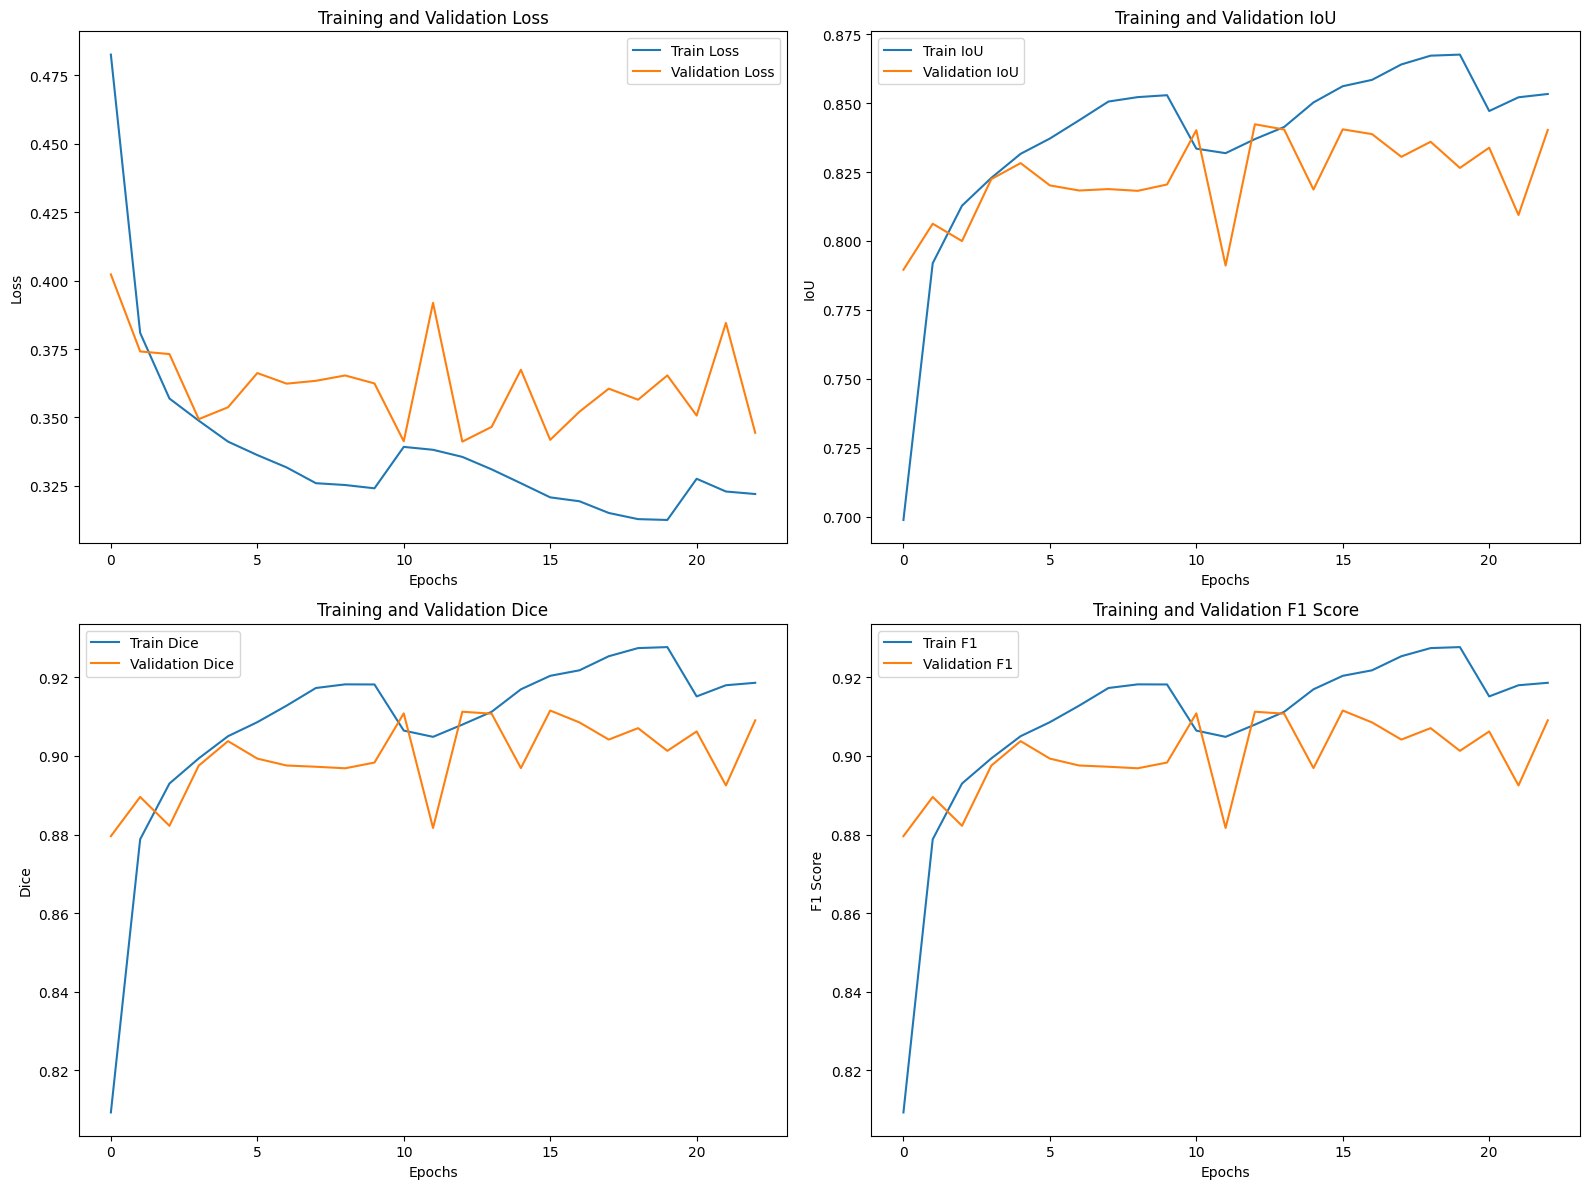

In [11]:
# Vẽ biểu đồ loss
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot([m['iou'] for m in train_metrics], label='Train IoU')
plt.plot([m['iou'] for m in val_metrics], label='Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot([m['dice'] for m in train_metrics], label='Train Dice')
plt.plot([m['dice'] for m in val_metrics], label='Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.title('Training and Validation Dice')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot([m['f1'] for m in train_metrics], label='Train F1')
plt.plot([m['f1'] for m in val_metrics], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.savefig('./results/training_history.png')
plt.show()

In [12]:
# Tải model tốt nhất theo IoU
try:
    checkpoint = torch.load('./models/best_model_iou.pth')
    print("Sử dụng model tốt nhất theo IoU.")
except:
    checkpoint = torch.load('./models/best_model_loss.pth')
    print("Sử dụng model tốt nhất theo Loss.")

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Đánh giá trên tập validation
val_metrics_final = {'iou': 0, 'dice': 0, 'precision': 0, 'recall': 0, 'f1': 0}

with torch.no_grad():
    for images, masks in tqdm(val_loader, desc="Đánh giá trên tập validation"):
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        
        batch_metrics = evaluate_metrics(outputs, masks)
        for k, v in batch_metrics.items():
            val_metrics_final[k] += v

# Tính giá trị trung bình cho các metrics
for k in val_metrics_final:
    val_metrics_final[k] /= len(val_loader)

print(f"Đánh giá mô hình trên tập validation:")
print(f"IoU: {val_metrics_final['iou']:.4f}")
print(f"Dice: {val_metrics_final['dice']:.4f}")
print(f"Precision: {val_metrics_final['precision']:.4f}")
print(f"Recall: {val_metrics_final['recall']:.4f}")
print(f"F1 Score: {val_metrics_final['f1']:.4f}")

Sử dụng model tốt nhất theo IoU.


Đánh giá trên tập validation:  54%|█████▍    | 14/26 [00:05<00:04,  2.79it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/LICENSE.txt


Đánh giá trên tập validation:  58%|█████▊    | 15/26 [00:05<00:03,  3.40it/s]

Không thể đọc file: /kaggle/input/isic-2018-task12/ISIC2018_Task1-2_Validation_Input/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt


Đánh giá trên tập validation: 100%|██████████| 26/26 [00:07<00:00,  3.45it/s]

Đánh giá mô hình trên tập validation:
IoU: 0.8423
Dice: 0.9112
Precision: 0.8936
Recall: 0.9379
F1 Score: 0.9112


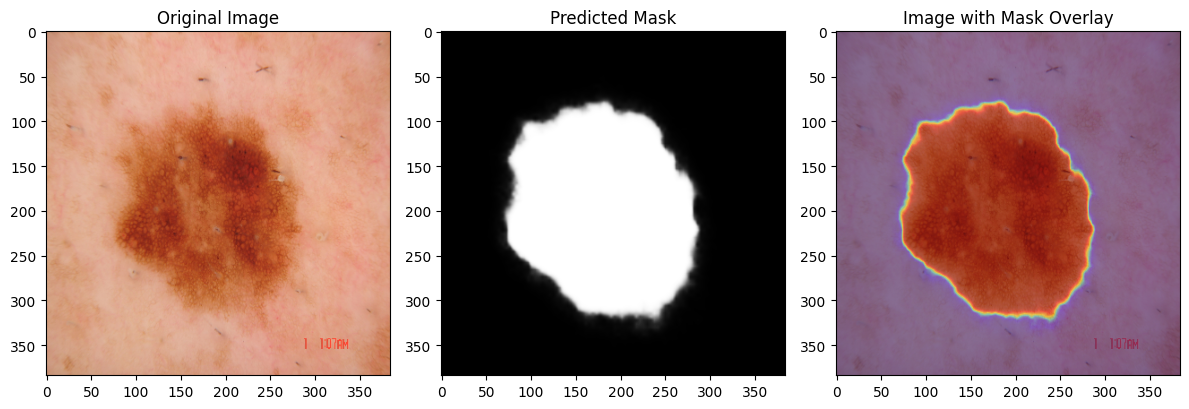

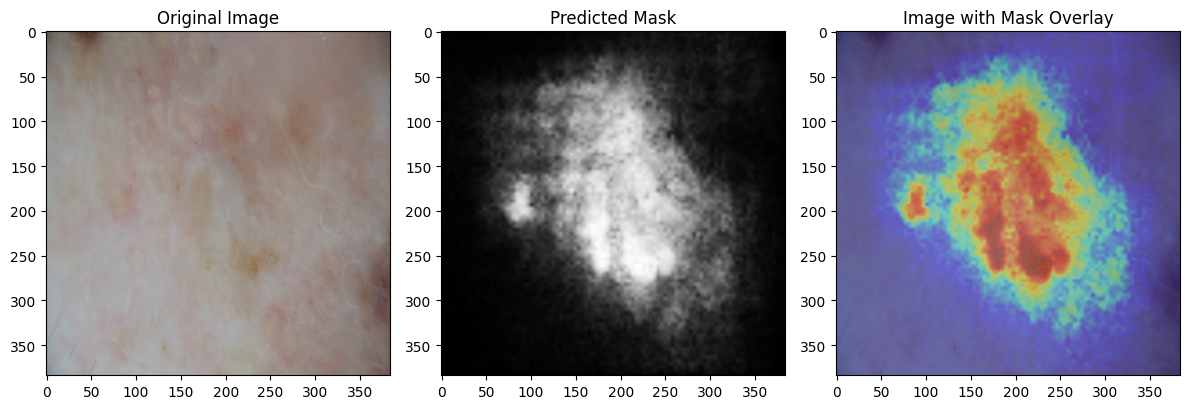

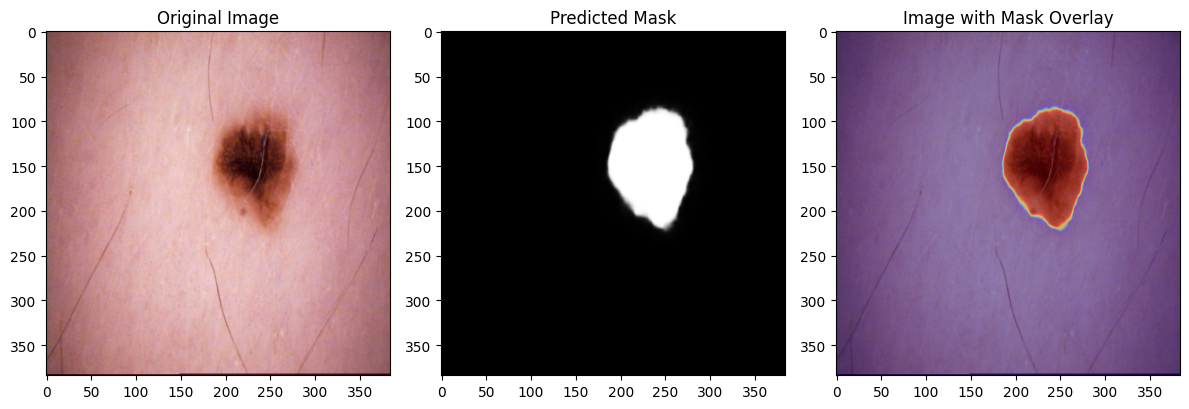

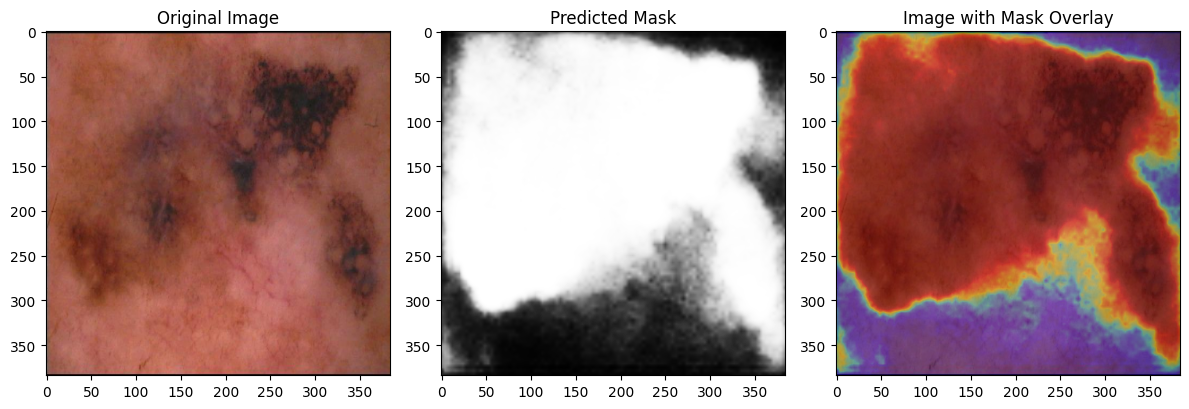

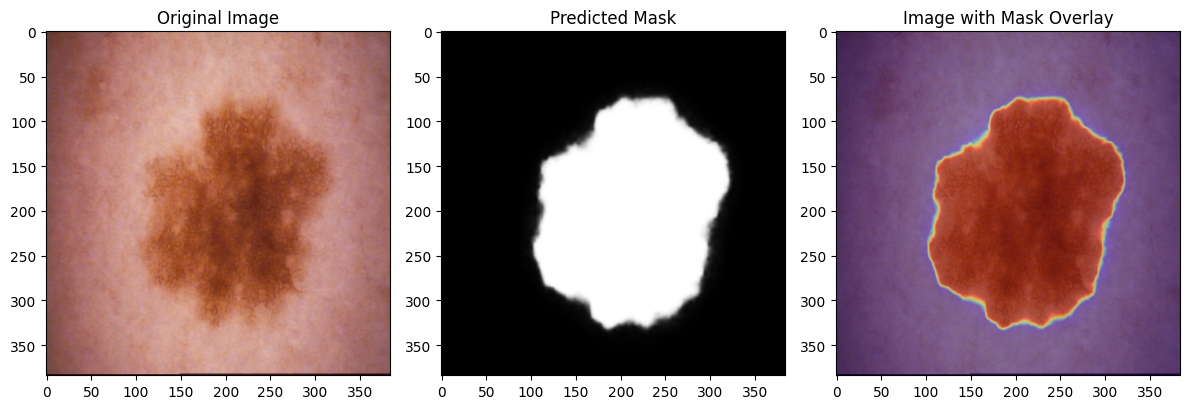

In [13]:
def predict_and_visualize(model, test_loader, device, num_samples=5):
    """Dự đoán và hiển thị một số mẫu từ tập test"""
    model.eval()
    
    with torch.no_grad():
        for i, (images, img_names) in enumerate(test_loader):
            if i >= num_samples:
                break
                
            images = images.to(device)
            outputs = model(images)
            
            # Chuyển đổi tensor về numpy để hiển thị
            img = images[0].cpu().numpy().transpose(1, 2, 0)
            # Denormalize
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            pred_mask = outputs[0, 0].cpu().numpy()
            
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title('Original Image')
            
            plt.subplot(1, 3, 2)
            plt.imshow(pred_mask, cmap='gray')
            plt.title('Predicted Mask')
            
            plt.subplot(1, 3, 3)
            plt.imshow(img)
            plt.imshow(pred_mask, alpha=0.4, cmap='jet')
            plt.title('Image with Mask Overlay')
            
            plt.tight_layout()
            plt.savefig(f'./results/prediction_{img_names[0]}')
            plt.show()

predict_and_visualize(model, test_loader, device)